# **Customer Segmentation and Behavior Analysis**

### Business Problem
The business is facing challenges in understanding customer behavior and effectively targeting different customer groups. There is a need to improve marketing strategies by identifying which customers are most valuable, which are at risk of leaving, and which ones are not engaged enough. The goal is to create personalized marketing campaigns that increase customer retention, boost repeat purchases, and maximize revenue by focusing on the right segments.

### Objectives
- Identify key customer segments
- Personalize communication with each group
- Improve marketing campaign effectiveness
- Enhance customer retention and loyalty
- Maximize customer lifetime value

### Project Stages
**Cohort Analysis**<br>
Analyze customer data over time to understand the buying behavior of groups that were acquired in different months. <br>

**RFM Analysis**<br>
Use the RFM model to assign scores to customers based on their recent activity, frequency of purchases, and total spending. This model will be used to segment customers into different groups.<br>

**Segmentation and Targeting** <br>
Segment customers into distinct categories and develop tailored marketing strategies for each group to improve engagement and retention. <br>

**K-Means Clustering** <br>
Use k-means clustering to group customers based on their RFM scores, identifying distinct customer types with similar behavior. This allows for the creation of more granular customer segments and the development of targeted marketing strategies for each cluster. 

In [131]:
# import libs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Data review
Project focuses on sales data analysis for a company based in the United Kingdom. The initial dataset consists of the following columns:
- InvoiceNo: identifier for the invoice.
- StockCode: product code used to identify items.
- Description: textual description of the product.
- Quantity: number of units of the product sold in a transaction.
- UnitPrice: price per unit of the product.
- CustomerID: identifier for the customer who made the purchase.
- InvoiceDate: date when the invoice was issued.

In [132]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")
df = df.drop(columns=["delete"])
df = df[df['Country'] == 'United Kingdom']
df = df.drop(columns=["Country"])
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,InvoiceDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,12/1/2020
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,12/1/2020
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,12/1/2020
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,12/1/2020
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,12/1/2020


### Data preparation

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495478 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   UnitPrice    495478 non-null  float64
 5   CustomerID   361878 non-null  float64
 6   InvoiceDate  495478 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 30.2+ MB


In [134]:
# check null values

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     133600
InvoiceDate         0
dtype: int64

In [135]:
# drop null values

df = df.dropna(subset=["CustomerID"])
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
InvoiceDate    0
dtype: int64

In [136]:
# check for a duplicate rows

df.duplicated().sum()

5151

In [137]:
# drop duplicate rows

df = df.drop_duplicates()
df.duplicated().sum()

0

In [138]:
# review data distribution

df.describe()

,Quantity,UnitPrice,CustomerID
count,356727.000000,356727.000000,356727.000000
mean,11.198670,3.268259,15543.797456
std,264.998415,71.162430,1594.287926
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15513.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [139]:
# remove abnormal data

df = df[(df["Quantity"]>0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,349226.000000,349226.000000,349226.000000
mean,12.181324,2.972127,15548.335857
std,191.797744,17.990333,1594.404814
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15518.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


In [140]:
df = df[(df["UnitPrice"]>1)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,267425.000000,267425.000000,267425.000000
mean,9.611603,3.697920,15553.863210
std,214.635861,20.503373,1591.134103
min,1.000000,1.010000,12346.000000
25%,2.000000,1.650000,14194.000000
50%,4.000000,2.250000,15516.000000
75%,10.000000,4.250000,16934.000000
max,80995.000000,8142.750000,18287.000000


In [141]:
# change data type for CustomerID, InvoiceNo and InvoiceDate

df['CustomerID'] = df['CustomerID'].astype(int) 
df['InvoiceNo'] = df['InvoiceNo'].astype(int) 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267425 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    267425 non-null  int32         
 1   StockCode    267425 non-null  object        
 2   Description  267425 non-null  object        
 3   Quantity     267425 non-null  int64         
 4   UnitPrice    267425 non-null  float64       
 5   CustomerID   267425 non-null  int32         
 6   InvoiceDate  267425 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2)
memory usage: 14.3+ MB


In [142]:
# define time frame for a project

print(df['InvoiceDate'].min(), df['InvoiceDate'].max())

2020-12-01 00:00:00 2021-12-09 00:00:00


In [143]:
df = df[df['InvoiceDate'] < '2021-12-01']
print(df['InvoiceDate'].min(), df['InvoiceDate'].max())

2020-12-01 00:00:00 2021-11-30 00:00:00


In [144]:
df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,InvoiceDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,2020-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,2020-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,2020-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,2020-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,2020-12-01
...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,1.25,15444,2021-11-30
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,5.95,15444,2021-11-30
516366,579885,23084,RABBIT NIGHT LIGHT,6,2.08,15444,2021-11-30
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,7.95,15444,2021-11-30


In [145]:
import warnings
warnings.filterwarnings('ignore')

### Cohort Analysis

In [146]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')
df['CohortIndex'] = (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month + 1
df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,InvoiceDate,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,2020-12-01,2020-12,2020-12,1
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,2020-12-01,2020-12,2020-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,2020-12-01,2020-12,2020-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,2020-12-01,2020-12,2020-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,2020-12-01,2020-12,2020-12,1
...,...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,1.25,15444,2021-11-30,2021-11,2021-10,2
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,5.95,15444,2021-11-30,2021-11,2021-10,2
516366,579885,23084,RABBIT NIGHT LIGHT,6,2.08,15444,2021-11-30,2021-11,2021-10,2
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,7.95,15444,2021-11-30,2021-11,2021-10,2


#### Customer cohort and Customer Retention

In [147]:
# customer cohort

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')


In [148]:
# customer retention cohort

cohort_retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0) * 100
cohort_retention = cohort_retention.round(2)

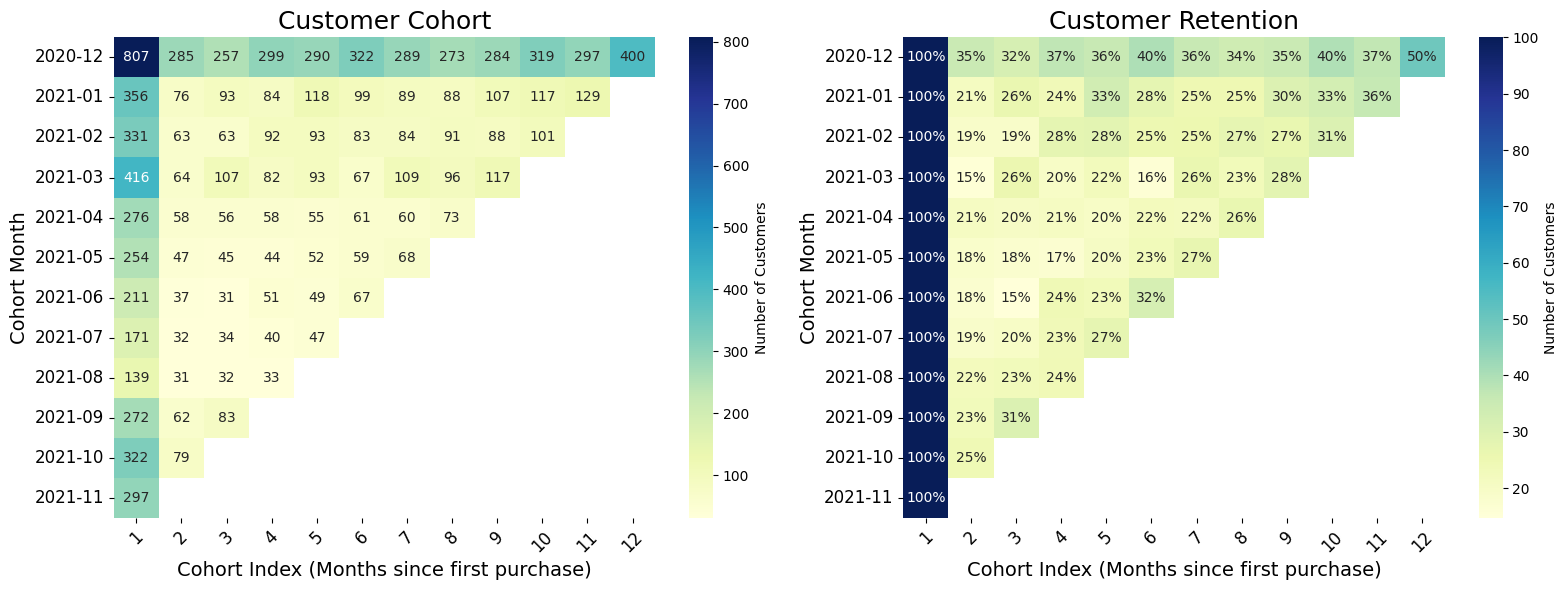

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Customers'}, ax=axes[0])
axes[0].set_title("Customer Cohort", fontsize=18)
axes[0].set_xlabel("Cohort Index (Months since first purchase)", fontsize=14)
axes[0].set_ylabel("Cohort Month", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', rotation=0, labelsize=12)

sns.heatmap(cohort_retention, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Customers'}, ax=axes[1])
for text in axes[1].texts:
    text.set_text(f"{int(float(text.get_text()))}%")
axes[1].set_title("Customer Retention", fontsize=18)
axes[1].set_xlabel("Cohort Index (Months since first purchase)", fontsize=14)
axes[1].set_ylabel("Cohort Month", fontsize=14)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', rotation=0, labelsize=12)

plt.tight_layout()
plt.show()


The retention rates across the cohorts show a decline in customer engagement as time progresses. The data clearly indicates that December 2020 was the month with the highest number of customer acquisitions, with 807 customers in the cohort. This suggests that the marketing efforts during this period were highly effective in attracting new customers. However, a closer look at the retention data reveals that only about 20% of the newly acquired customers remained engaged in the following month, with even fewer continuing to make purchases in subsequent months. 
The fluctuations in retention percentages across months highlight a degree of seasonal variation, with some months showing a small improvement in retention, especially around the 10th and 12th months.

#### Revenue and Revenue Retention

In [150]:
# calc revenue

df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [151]:
# revenue cohort

cohort_revenue = df.groupby(['CohortMonth', 'CohortIndex'])['Revenue'].sum().reset_index()
cohort_revenue = cohort_revenue.round(0)
cohort_revenue_pivot = cohort_revenue.pivot(index='CohortMonth', columns='CohortIndex', values='Revenue')

In [152]:
# revenue retention

cohort_revenue_retention = cohort_revenue_pivot.divide(cohort_revenue_pivot.iloc[:, 0], axis=0) * 100
cohort_revenue_retention = cohort_revenue_retention.round(2)

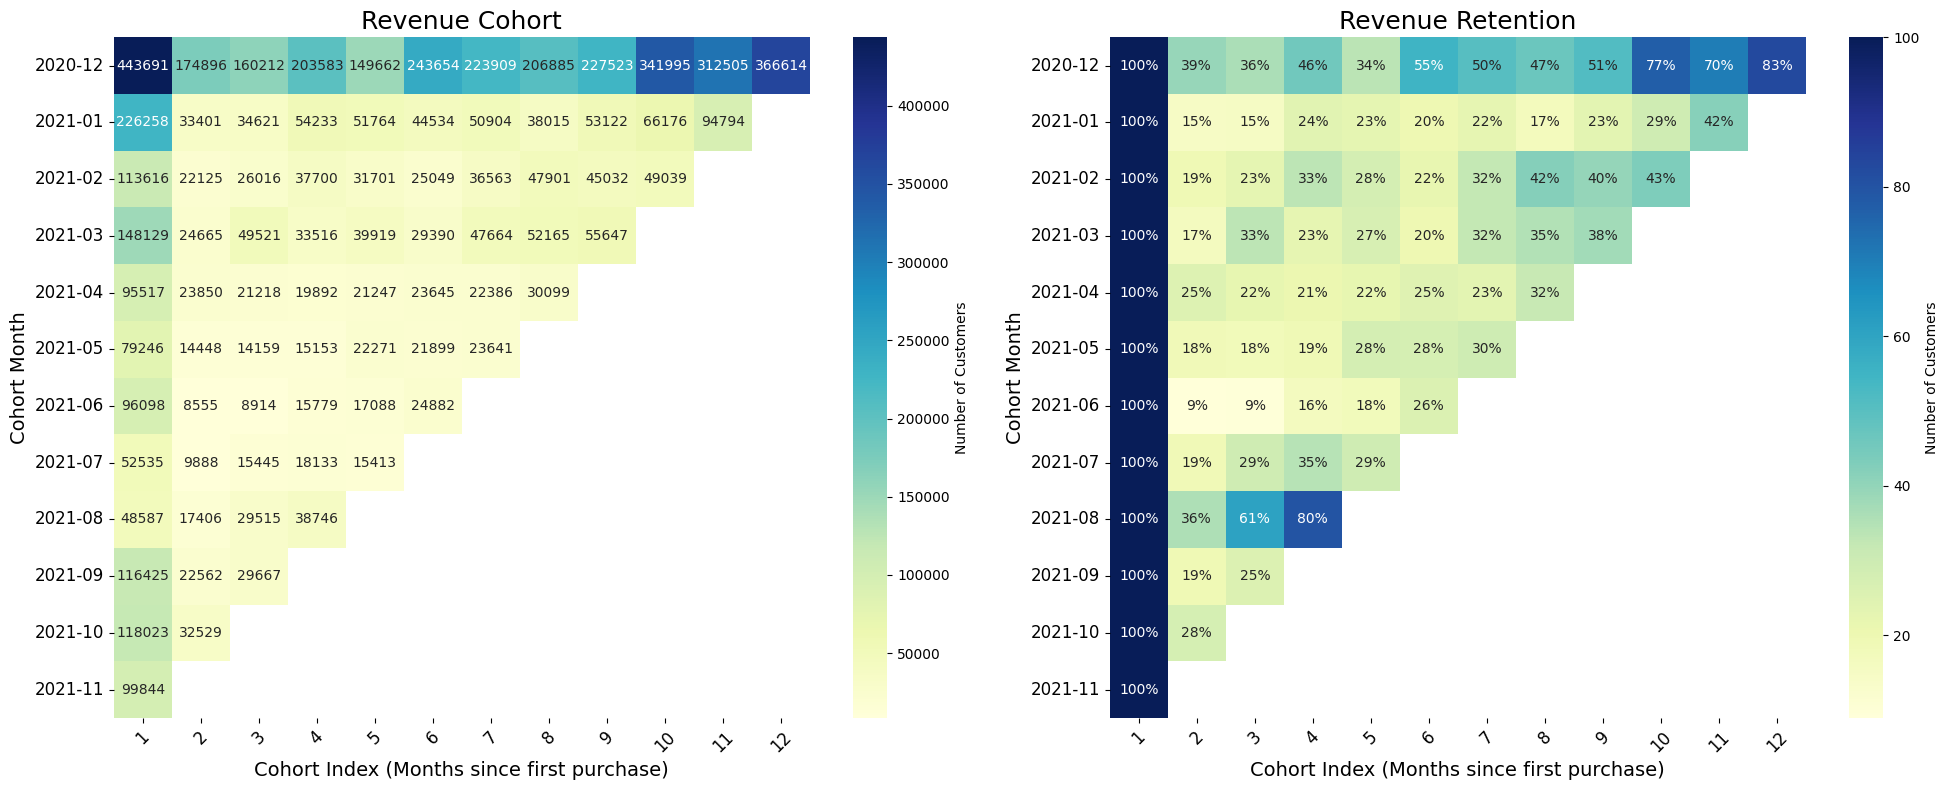

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) 

sns.heatmap(cohort_revenue_pivot, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Customers'}, ax=axes[0])
axes[0].set_title("Revenue Cohort", fontsize=18)
axes[0].set_xlabel("Cohort Index (Months since first purchase)", fontsize=14)
axes[0].set_ylabel("Cohort Month", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', rotation=0, labelsize=12)

sns.heatmap(cohort_revenue_retention, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Customers'}, ax=axes[1])
for text in axes[1].texts:
    text.set_text(f"{int(float(text.get_text()))}%")
axes[1].set_title("Revenue Retention", fontsize=18)
axes[1].set_xlabel("Cohort Index (Months since first purchase)", fontsize=14)
axes[1].set_ylabel("Cohort Month", fontsize=14)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', rotation=0, labelsize=12)

plt.tight_layout()
plt.show()


The highest revenue in the cohort analysis came from the December 2020 group, with a significant initial income of $443,691. Over the course of 12 months, these customers contributed an additional 83% of the revenue, highlighting their importance in driving sustained sales even after the first month. In comparison, the August 2021 cohort generated 80% of its revenue by the 12th month, demonstrating that customers from later months still contributed significantly but at a lower rate.

However, the data also reveals that customers are not inclined to make repeat purchases, which significantly impacts retention rates. This leads to a decline in revenue throughout the year, as customers tend to disengage after their initial purchase. Despite this, there was a revenue recovery towards the end of the year, particularly around the holiday season, which reinforces the presence of seasonality in customer purchasing behavior. The increase in revenue near the end of the year, especially during the New Year period, underscores the effectiveness of seasonal promotions and suggests that targeted campaigns around key holidays can drive higher customer engagement and revenue.

#### Customer Cumulative Revenue and Life Time Revenue

In [154]:
# cumulative revenue

cohort_revenue_cumulative = cohort_revenue_pivot.cumsum(axis=1)

In [155]:
# lifetime revenue

cohort_lifetime_revenue = cohort_revenue_cumulative.div(cohort_pivot.iloc[:, 0], axis=0)
cohort_lifetime_revenue = cohort_lifetime_revenue.round(0)

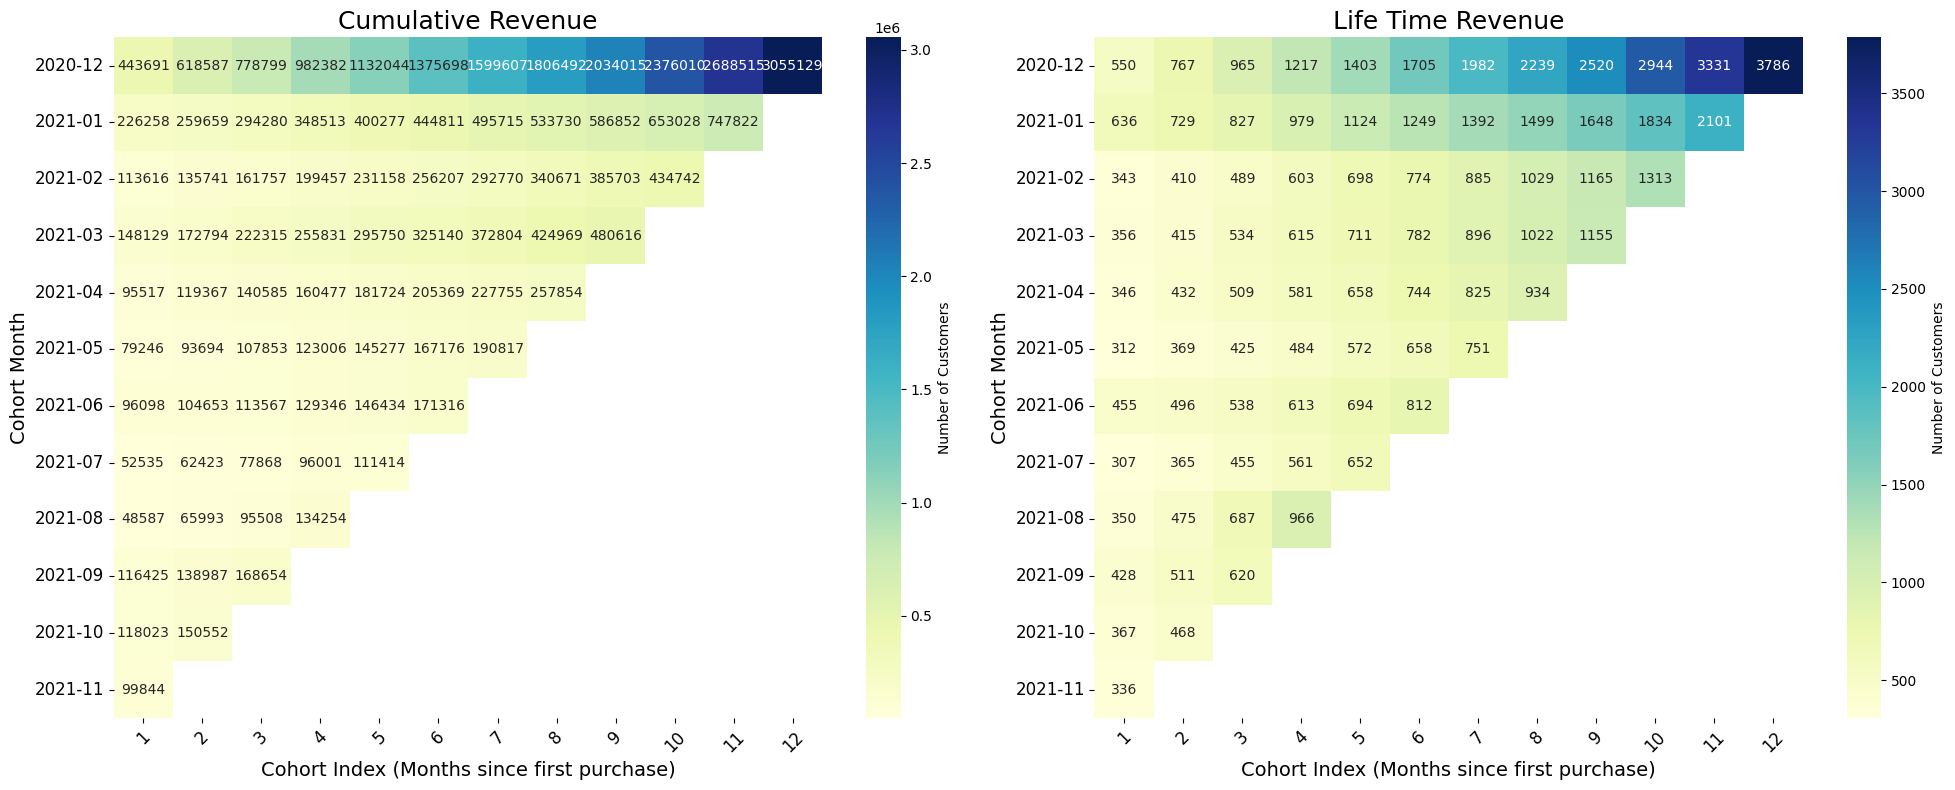

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cohort_revenue_cumulative, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Customers'}, ax=axes[0])
axes[0].set_title("Cumulative Revenue", fontsize=18)
axes[0].set_xlabel("Cohort Index (Months since first purchase)", fontsize=14)
axes[0].set_ylabel("Cohort Month", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', rotation=0, labelsize=12)

sns.heatmap(cohort_lifetime_revenue, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Customers'}, ax=axes[1])
axes[1].set_title("Life Time Revenue", fontsize=18)
axes[1].set_xlabel("Cohort Index (Months since first purchase)", fontsize=14)
axes[1].set_ylabel("Cohort Month", fontsize=14)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', rotation=0, labelsize=12)

plt.tight_layout()
plt.show()


The cumulative revenue analysis reveals that the December 2020 cohort generated the highest revenue, starting at $443,691 in the first month and reaching $3,055,129 by the 12th month. This cohort's strong initial performance and continued engagement underscore the effectiveness of holiday-period marketing, with customers continuing to make purchases over time. In contrast, customers acquired in later months, such as January 2021 and February 2021, showed slower revenue growth, with their cumulative contributions being lower. This trend highlights the seasonal impact of customer behavior, with higher revenue being driven by holiday seasons like December, followed by a decline in purchases in non-holiday months, emphasizing the importance of seasonally targeted marketing strategies to boost both immediate and long-term sales. <br>

The lifetime revenue analysis highlights the enduring value of customers acquired in December 2020. These customers exhibited a steady increase in their lifetime spend, with the cohort starting at $550 in the first month and growing to $3,786 by the 12th month. This consistent increase in lifetime revenue indicates strong customer loyalty and suggests that December 2020 buyers were more likely to make repeat purchases over the year, contributing significantly to the overall revenue.

### RFM Analysis

In [157]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,InvoiceDate,InvoiceMonth,CohortMonth,CohortIndex,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,2020-12-01,2020-12,2020-12,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,2020-12-01,2020-12,2020-12,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,2020-12-01,2020-12,2020-12,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,2020-12-01,2020-12,2020-12,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,2020-12-01,2020-12,2020-12,1,20.34


In [158]:
import datetime
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)
snapshot_date

Timestamp('2021-12-01 00:00:00')

In [159]:
# Recency
recency = df.groupby('CustomerID')['InvoiceDate'].max()
recency = (snapshot_date - recency).dt.days

# Frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Monetary 
monetary = df.groupby('CustomerID')['Revenue'].sum()

rfm = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

rfm.describe()

,Recency,Frequency,Monetary
count,3852.000000,3852.000000,3852.000000
mean,91.490395,4.051661,1558.415358
std,98.342787,6.736050,6462.324029
min,1.000000,1.000000,1.250000
25%,16.000000,1.000000,244.650000
50%,49.000000,2.000000,540.740000
75%,147.000000,4.000000,1299.167500
max,365.000000,184.000000,246033.360000


**Recency** <br>
On average, the customers made their most recent purchase about 91 days ago, with the range spanning from 1 day to 365 days. A high standard deviation (98.15) indicates significant variation in customer recency, suggesting some customers make frequent, recent purchases, while others have lapsed. <br>

**Frequency** <br>
Customers, on average, made about 4 purchases. <br>

**Monetary** <br>
The average monetary value per customer is $1,558.

In [160]:
def assign_weights(rfm_column, invert=False):
    bin_edges, bins = pd.qcut(rfm_column, 4, labels=False, retbins=True, duplicates='drop')
    if len(bins) > 4:
        labels = [1, 2, 3, 4]
    else:
        labels = [1, 2, 3]
    
    if invert:
        labels = labels[::-1] 
    
    return pd.cut(rfm_column, bins=bins, labels=labels, include_lowest=True)

rfm['Recency_weight'] = assign_weights(rfm['Recency'], invert=True)
rfm['Frequency_weight'] = assign_weights(rfm['Frequency']) 
rfm['Monetary_weight'] = assign_weights(rfm['Monetary'])
rfm['RFM_Score'] = rfm['Recency_weight'].astype(int) + rfm['Frequency_weight'].astype(int) + rfm['Monetary_weight'].astype(int)
rfm = rfm.sort_values('RFM_Score', ascending=False)
rfm


,Recency,Frequency,Monetary,Recency_weight,Frequency_weight,Monetary_weight,RFM_Score
CustomerID,,,,,,,
15570,2,11,3701.57,4,3,4,11
16076,14,8,1780.77,4,3,4,11
16133,8,30,12373.58,4,3,4,11
16128,9,5,1743.18,4,3,4,11
16115,1,8,1373.61,4,3,4,11
...,...,...,...,...,...,...,...
16634,214,2,217.90,1,1,1,3
15386,178,1,230.70,1,1,1,3
16647,161,2,139.50,1,1,1,3


In [161]:
def segments(df):
    if df['RFM_Score'] > 9:
        return 'Loyal Customers'
    elif (df['RFM_Score'] > 6) and (df['RFM_Score'] <= 9):
        return 'Potential Customers'
    elif (df['RFM_Score'] > 3) and (df['RFM_Score'] <= 6):
        return 'At-Risk Customers'
    else:
        return 'Inactive Customers'

rfm['RFM_Segment'] = rfm.apply(segments, axis=1)
rfm['RFM_Segment'].value_counts()

RFM_Segment
At-Risk Customers      1539
Potential Customers    1123
Loyal Customers         750
Inactive Customers      440
Name: count, dtype: int64

Out of all customers, 40% are At-Risk Customers, 29% are Potential Customers, 19% are Loyal Customers, and 11% are Inactive Customers. This distribution shows that most customers are either at risk or still in the potential phase, signaling the need for strategies to retain and convert these groups. The relatively small share of loyal customers suggests that efforts to nurture and re-engage these customers, along with addressing at-risk and inactive groups, are crucial for boosting long-term retention and profitability.

In [162]:
rfm.groupby('RFM_Segment').agg({'Recency':'mean','Frequency':'mean', 'Monetary':'mean'}).round(1)

,Recency,Frequency,Monetary
RFM_Segment,,,
At-Risk Customers,116.0,1.5,420.3
Inactive Customers,255.5,1.1,136.2
Loyal Customers,13.9,11.5,5182.4
Potential Customers,45.5,3.7,1255.1


### Summary
**Loyal Customers** are highly engaged, frequent buyers with significant spending. <br>
**At-Risk Customers** need to be nurtured with targeted re-engagement campaigns, as they show potential but have decreased frequency and recency. <br>
**Inactive Customers** are the least engaged, and strategies to win them back should be tailored to reactivate their interest, but the chances are slim without personalized efforts. <br>
**Potential Customers** are a promising group that could be converted into loyal customers with the right incentives or offers. <br>

In [163]:
rfm

,Recency,Frequency,Monetary,Recency_weight,Frequency_weight,Monetary_weight,RFM_Score,RFM_Segment
CustomerID,,,,,,,,
15570,2,11,3701.57,4,3,4,11,Loyal Customers
16076,14,8,1780.77,4,3,4,11,Loyal Customers
16133,8,30,12373.58,4,3,4,11,Loyal Customers
16128,9,5,1743.18,4,3,4,11,Loyal Customers
16115,1,8,1373.61,4,3,4,11,Loyal Customers
...,...,...,...,...,...,...,...,...
16634,214,2,217.90,1,1,1,3,Inactive Customers
15386,178,1,230.70,1,1,1,3,Inactive Customers
16647,161,2,139.50,1,1,1,3,Inactive Customers


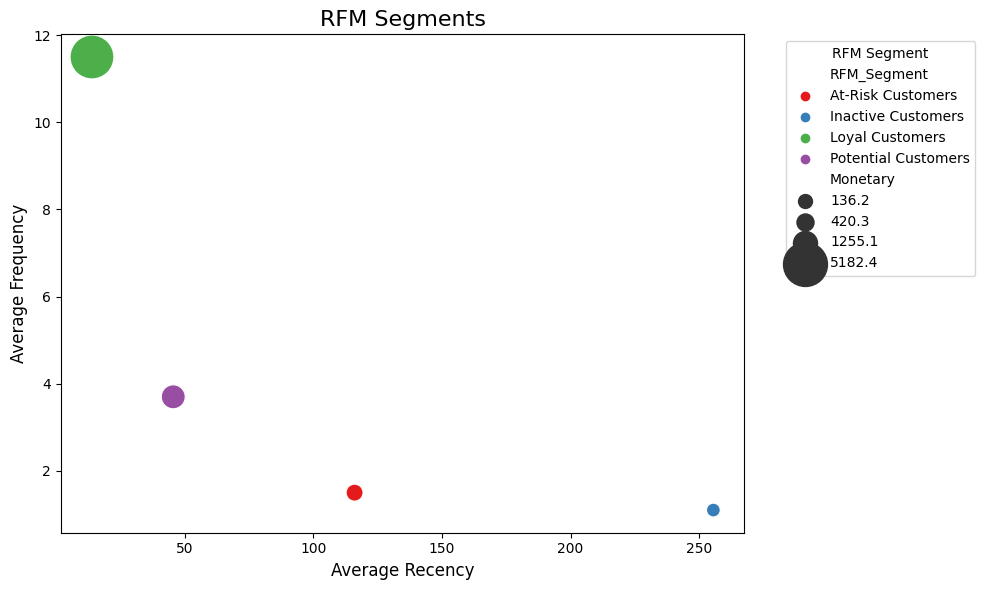

In [165]:
agg_rfm = rfm.groupby('RFM_Segment').agg({'Recency':'mean','Frequency':'mean', 'Monetary':'mean'}).round(1)
agg_rfm = agg_rfm.reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', size='Monetary', hue='RFM_Segment', data=agg_rfm, palette='Set1', sizes=(100, 1000), legend='full')

plt.title('RFM Segments', fontsize=16)
plt.xlabel('Average Recency', fontsize=12)
plt.ylabel('Average Frequency', fontsize=12)
plt.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Clustering using K-means

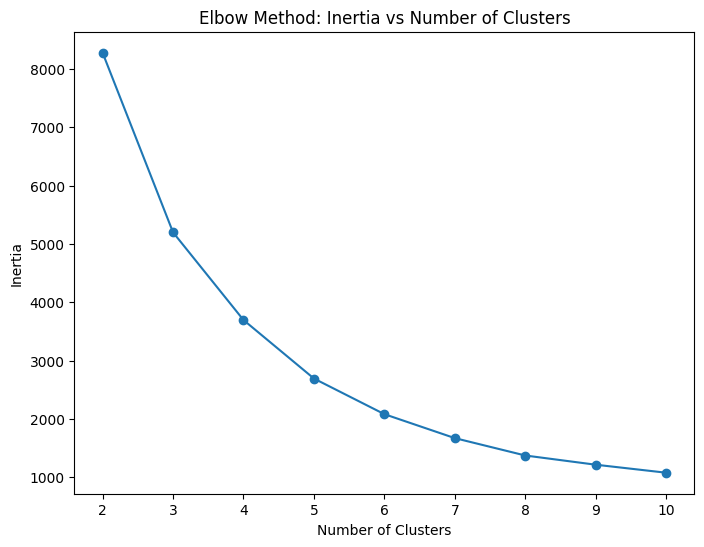

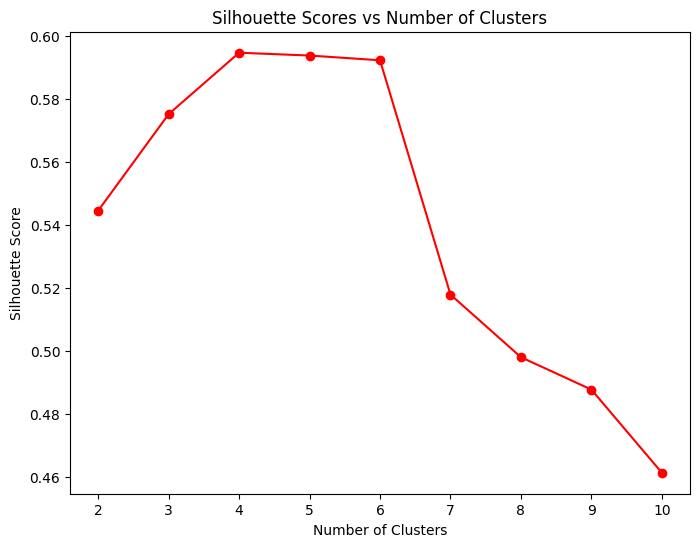

In [166]:
# Determine the optimal number of clusters

rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data) 

inertia = [] 
silhouette_scores = []

for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method: Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='red')
plt.title('Silhouette Scores vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [167]:
optimal_k = 4 

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_summary)

sil_score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {sil_score:.3f}')

            Recency  Frequency       Monetary
Cluster                                      
0        238.494024   1.544821     384.717779
1         22.156627  33.277108   20790.776988
2         40.220413   4.051031    1250.273699
3          2.500000  50.500000  218309.295000
Silhouette Score: 0.595


#### Summary

**Cluster 0** - inactive customers. They need campaigns aimed at re-engagement or retention strategies. <br>
**Cluster 1** - loyal customers with high spending. They are the core group for repeat sales and should be targeted with loyalty programs to retain them. <br>
**Cluster 2** - potential customers who are already purchasing but with less frequency and lower spending. Marketing strategies should focus on increasing their activity and spending. <br>
**Cluster 0** - high-value customers, they should be engaged with personalized offers, VIP programs, and other retention strategies to ensure their continued business. <br>

- Cluster 1 and 3 are the most valuable segments in terms of revenue and loyalty and should be prioritized with retention and engagement strategies.
- Cluster 2 includes potential customers who can be converted into more frequent and higher-spending buyers with personalized offers and campaigns.
- Cluster 0 contains inactive customers who need re-engagement efforts to bring them back into the fold.

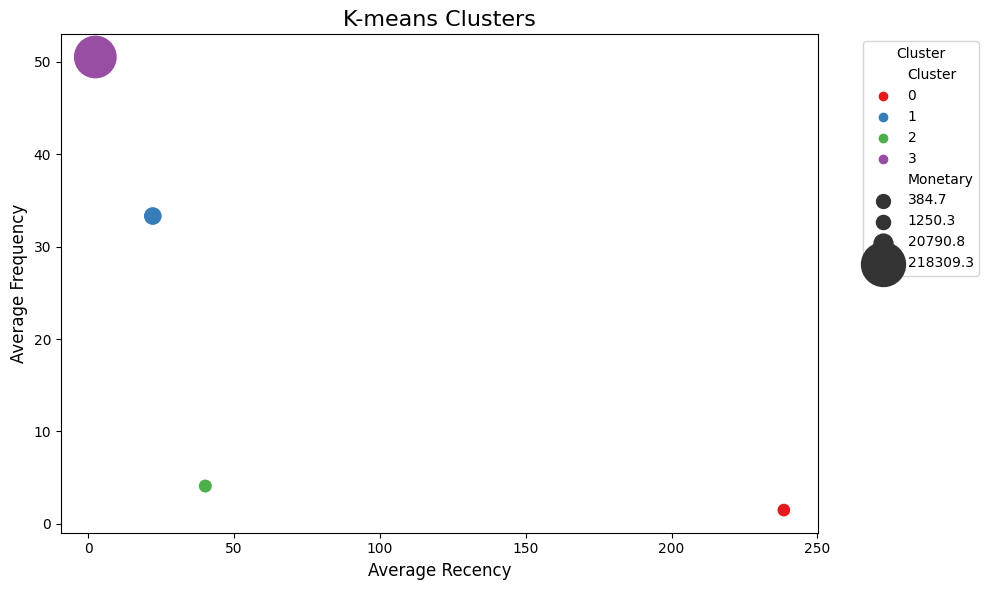

In [170]:
agg_rfm = rfm.groupby('Cluster').agg({'Recency':'mean','Frequency':'mean', 'Monetary':'mean'}).round(1)
agg_rfm = agg_rfm.reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', size='Monetary', hue='Cluster', data=agg_rfm, palette='Set1', sizes=(100, 1000), legend='full')

plt.title('K-means Clusters', fontsize=16)
plt.xlabel('Average Recency', fontsize=12)
plt.ylabel('Average Frequency', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [169]:
rfm

,Recency,Frequency,Monetary,Recency_weight,Frequency_weight,Monetary_weight,RFM_Score,RFM_Segment,Cluster
CustomerID,,,,,,,,,
15570,2,11,3701.57,4,3,4,11,Loyal Customers,2
16076,14,8,1780.77,4,3,4,11,Loyal Customers,2
16133,8,30,12373.58,4,3,4,11,Loyal Customers,1
16128,9,5,1743.18,4,3,4,11,Loyal Customers,2
16115,1,8,1373.61,4,3,4,11,Loyal Customers,2
...,...,...,...,...,...,...,...,...,...
16634,214,2,217.90,1,1,1,3,Inactive Customers,0
15386,178,1,230.70,1,1,1,3,Inactive Customers,0
16647,161,2,139.50,1,1,1,3,Inactive Customers,0


### Conclusion
A comprehensive analysis of consumer behaviour was conducted using three key approaches: cohort analysis, RFM segmentation and clustering.  <br>

Cohort analysis revealed important patterns in customer retention and engagement. December cohorts generated the highest revenue, with consistent lifetime revenue growth, indicating strong retention. Seasonal trends, especially around the New Year, were identified, showing that customers are more likely to engage with promotions during this time. These insights allow businesses to focus on high-value customers and re-engage those at risk of churn. <br>

RFM segmentation classified customers into segments based on recency, frequency, and monetary value. Customers were categorized into groups like "Loyal Customers" "Potential Customers", "At-Risk Customer", and "Inactive Customers". This segmentation helps businesses prioritize high-value customers for loyalty programs while targeting less engaged ones for re-engagement efforts. <br>

K-means clustering further refined the analysis, identifying four customer clusters. Cluster 1 included loyal, high-spending customers, Cluster 3 consisted of frequent buyers with growth potential, Cluster 2 represented moderate spenders, and Cluster 0 comprised inactive customers. These clusters provided deeper insights into customer behavior, enabling the development of tailored marketing strategies to enhance customer value and retention. <br>

In summary, this analysis provides a clear understanding of customer behavior, helping businesses optimize marketing efforts, improve retention, and foster long-term growth.